# Tutorial for interpreting vision transformers mechanisms in class embedding space

This tutorial will showcase how to use the interpretability method introduced in [Analyzing Vision Transformers for Image Classification in Class Embedding Space](https://arxiv.org/abs/2310.18969) (NeurIPS 2023) by Martina G. Vilas, Timothy Schaumlöffel and Gemma Roig.

Table of Contents:
1. [Loading the model](#Loading-the-model)
2. [Projecting hidden states onto class embedding space](#Projecting-hidden-states-to-class-embedding-space): 
3. [Projecting parameters onto class embedding space](#Projecting-parameters-to-class-embedding-space)
4. [Explainabilty method](#Explainability-method)

## Loading the model

We will use as an example the vanilla vision transformer ViT-B/16 pre-trained for image classification using the ImageNet-21k dataset and fine-tuned on ImageNet-1k. 

We will access this model using the [timm](https://github.com/huggingface/pytorch-image-models) pytorch library:

In [1]:
from timm import create_model
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model('vit_base_patch16_224', pretrained=True).to(device)
model = model.eval()

/Users/m_vilas/opt/miniconda3/envs/vit-cls-emb/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vanilla image-classification ViTs take as input a sequence of linear projections of equal-sized $n$ image patches with added position embeddings. 
We refer to these as image tokens $\langle \mathbf{x}_{1}, \dots, \mathbf{x}_{n} \rangle$ with $\mathbf{x} \in \mathbb{R}^d$. 
The sequence also includes a special "class token" whose initial representation is learned during training, denoted here as [CLS]. 
Hence, we have $S= \langle \mathbf{x}^0_{cls}, \mathbf{x}^0_{1}, \dots, \mathbf{x}^0_{n} \rangle $ as the input of ViT.

The sequence $S$ is processed by a series of transformer blocks composed of interleaving multi-head self-attention (MHSA) and MLP layers, with residual connections between each of the layers.

Let's explore these layers on an example block in the loaded model:

In [2]:
print(model.blocks[0])

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)


Each $b^{\text{th}}$ block updates the inner representation (a.k.a. hidden state) $\mathbf{x}_i^{b-1} \in \mathbb{R}^d$ of each token $x_i \in S$ indexed by $i$, producing a new hidden state $\mathbf{x}_i^{b}$. 

Given a set of classes $C$ and a class embedding matrix $\mathbf{E} \in \mathbb{R}^{|C| \times d}$ which is learned during training, the predicted class probabilities are obtained by projecting the output of the [CLS] token of the last block and applying a softmax: $\mathbf{p}_{\text{cls}} = \text{softmax}(\mathbf{E} \cdot \mathbf{x}_{\text{cls}}^{b_n})$. 

We assume each row of $\mathbf{E}$ represents a __class prototype__ since they encode the patterns whose detection (via matrix multiplication with the [CLS] token) determines the probability of a class being present in the image.

In our loaded model, the embedding matrix $\mathbf{E}$ corresponds to the sub-module named `.head`:

In [3]:
cls_proj = model.head
print(cls_proj)

Linear(in_features=768, out_features=1000, bias=True)


Usually, before projecting $\mathbf{x}_{cls}^{b_n}$ onto the class embedding space, a layer normalization is applied to the hidden representation, such that $\mathbf{p}_{\text{cls}} = \text{softmax}(\mathbf{E} \cdot \text{ln}(\mathbf{x}_{\text{cls}}^{b_n}))$.
In our loaded model, this layer normalization is encoded in the module named `.norm`:

In [4]:
ln = model.norm
print(ln)

LayerNorm((768,), eps=1e-06, elementwise_affine=True)


## Projecting hidden states onto class embedding space

We propose that to investigate how class representations emerge in ViT, we can measure the alignment between the intermediate representations of the tokens with the class prototypes encoded by the final projection matrix $\mathbf{E}$.

We can probe the alignment by projecting onto the class embedding space the intermediate representations of the $i^{\text{th}}$ token in the $b^{\text{th}}$ block, such that $\mathbf{p}_i^b= \mathbf{E} \cdot \mathbf{x}^b_i $.

<center><img src="./images/framework_1.png" width="300" height="150"></center>

As depicted in the image, we can also project the outputs of the MHSA and MLP layers to the class embedding space, to measure how these sub-modules independently introduce class prototype representations.

To project the hidden representations of the model, we need to extract the intermediate representations of our loaded ViT. 
We thus need to define the names of the modules of the network from which we want to extract the representations:

In [5]:
layer_types = ['attn.proj', 'mlp.fc2', 'add_1']
layers = [f'blocks.{b}.{lt}' for b in range(12) for lt in layer_types]

Here, `attn.proj` is the output of the self-attention layer, `mlp.fc2` is the output of the MLP layer, and `add_1` is the ouput of the whole block.
These module names were identified using the method `get_graph_node_names` implemented in _torchvision_ (read [documentation](https://pytorch.org/vision/stable/feature_extraction.html)).

We can now add the feature extractor to our ViT using the method `create_feature_extractor` from _torchvision_:

In [6]:
from torchvision.models.feature_extraction import create_feature_extractor

extractor = create_feature_extractor(model, layers)

Let's now import an image of the ImageNet-1k dataset corresponding to the class `beagle` with class index `162`:

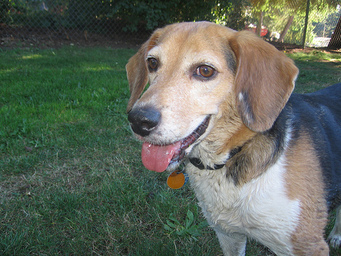

In [7]:
from PIL import Image

img = Image.open('./images/sample_0.JPEG')
class_idx = 162
display(img)

We need to pre-process the image before running it through the model:

In [8]:
from transformers import AutoImageProcessor

img_transform = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
img_ft = img_transform(img, return_tensors='pt')['pixel_values'].to(device)

We can now extract the hidden representations:

In [9]:
out = extractor(img_ft)

As output, we obtain a dictionary containing the intermediate representations of the requested layers:

In [10]:
print(out.keys())

dict_keys(['blocks.0.attn.proj', 'blocks.0.mlp.fc2', 'blocks.0.add_1', 'blocks.1.attn.proj', 'blocks.1.mlp.fc2', 'blocks.1.add_1', 'blocks.2.attn.proj', 'blocks.2.mlp.fc2', 'blocks.2.add_1', 'blocks.3.attn.proj', 'blocks.3.mlp.fc2', 'blocks.3.add_1', 'blocks.4.attn.proj', 'blocks.4.mlp.fc2', 'blocks.4.add_1', 'blocks.5.attn.proj', 'blocks.5.mlp.fc2', 'blocks.5.add_1', 'blocks.6.attn.proj', 'blocks.6.mlp.fc2', 'blocks.6.add_1', 'blocks.7.attn.proj', 'blocks.7.mlp.fc2', 'blocks.7.add_1', 'blocks.8.attn.proj', 'blocks.8.mlp.fc2', 'blocks.8.add_1', 'blocks.9.attn.proj', 'blocks.9.mlp.fc2', 'blocks.9.add_1', 'blocks.10.attn.proj', 'blocks.10.mlp.fc2', 'blocks.10.add_1', 'blocks.11.attn.proj', 'blocks.11.mlp.fc2', 'blocks.11.add_1'])


Each of these intermediate representations has the size of `[number of images in batch, number of tokens, dimension of hidden representation]`:

In [11]:
print(out['blocks.0.attn.proj'].shape)

torch.Size([1, 197, 768])


We can project the intermediate representations of all tokens to the class embedding space using the class projection layer `cls_proj` and the layer norm `ln` (both defined in the first section of this tutorial). Let's project the representations of `block 10`:

In [12]:
proj = cls_proj(ln(out['blocks.10.add_1'])).detach()
print(proj.shape)

torch.Size([1, 197, 1000])


We obtain the predicted class distribution for each token. 
As an example, let's print the class distribution of the [CLS] token:

Top-1 class: 166


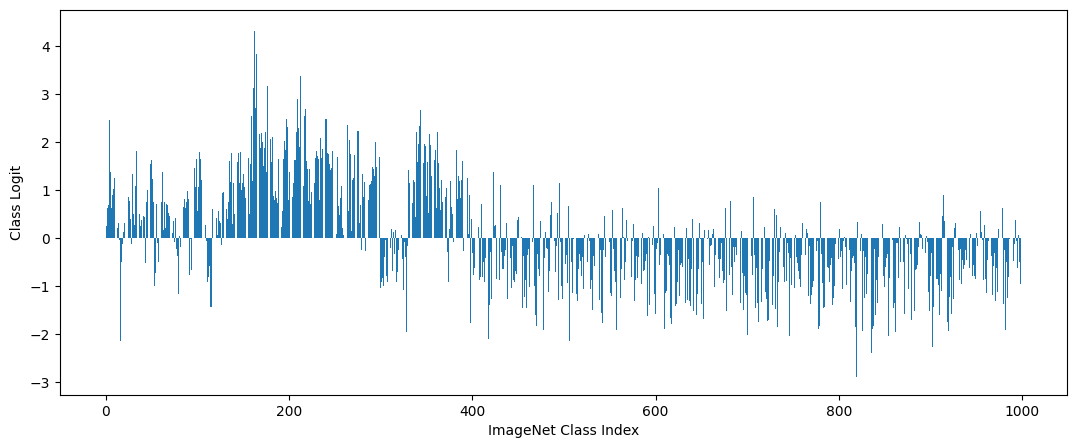

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Get CLS projection
proj_cls = (proj[0,0].numpy())

# Print class with largest logits
idx_max = np.argmax(proj_cls)
print(f'Top-1 class: {idx_max}')

# Plot class distribution
fig, ax = plt.subplots(figsize=(13, 5))
ax.bar(np.arange(1000), proj[0,0].numpy())
ax.set_ylabel('Class Logit')
ax.set_xlabel('ImageNet Class Index')
plt.show()

To explore how the correct class representation is encoded at these stages, we can create a function that:
1. Sorts the projected logits assigned to each class from higher to lower
2. Returns the index of the correct class in the sorted vector

In [16]:
def get_class_pos(proj, class_idx):
    ordered_idx = torch.argsort(proj, dim=2, descending=True)
    label_idx = (ordered_idx == class_idx).nonzero()
    return label_idx[:, 2]

We can now get the correct class index for all tokens in the layer:

In [17]:
print(get_class_pos(proj, class_idx))

tensor([  1, 554, 484, 364,  75, 673, 555, 455, 272, 242, 358, 380, 502,  62,
        316,  93,  75,  20,  76, 102,  76,   0,   0,   0,   0, 176, 118, 120,
        284,  10,  19,  83,  67,  78,   0,   1,   0,   1,   0,   0,   4, 195,
        276,  31, 173,  22,  82,  76,   1,   1,   1,   3,   1,   0,   0,   8,
        137,  39,   5, 631,   0,  16,   0,   3,   2,   0,   0,   0,   0,   0,
          0,  10,   2,   4,  16,  24,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   2,   4,  18,  25,   2,   1,   0,   0,   1,   0,   0,  17,   0,
          0,  13, 433,   7,   0,  19,   0,   0,  26,   0,   0,   0,   0,   0,
          0,   9,  17, 238, 806,  21,  81, 104,   6,   0,   0,   0,   0,   0,
          0,  38,   0,  17,  29,   2,   3,  30, 289,  50,   0,   0,   0,   0,
          0,   4,  28,   7,   0,   0,   3,   8, 254,   1,   0,   1,   0,   0,
          0,   2,   3,  52,   0,   2, 611,   2, 221,   1,   0,   0,   0,   0,
          0,   6,   2, 791,   3,   1,   2,   0, 323,   0,   0,  

We find that the correct class prototype representation in the [CLS] token comes second in the sorted vector (i.e. pos `1`). However, some image tokens already have encoded as strongest the correct class prototype representation (i.e. pos `0`).

Let's see what happens if we project the output of the MLP layer instead:

In [18]:
proj = cls_proj(ln(out['blocks.10.mlp.fc2']))
get_class_pos(proj, class_idx)

tensor([  1, 145, 369, 107,  34, 229, 415, 235, 145, 203, 167, 307, 328,  24,
        322,  35,  51,  37,  45,  38,  51,   0,   0,   0,   0, 140,  36,  14,
        158,  14,  41,  34,  33,  33,   0,   0,   0,   0,   1,   0,   9, 157,
        110,  19,  95,  58,  34,  58,   1,   0,   0,   0,   1,   0,   0,  14,
         82,  35,  29,  58,   6,  25,   0,   3,   3,   0,   0,   0,   0,   0,
          0,  17,   7,  14,  13,  46,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   4,  18,  54,  29,   4,   1,   0,   0,   0,   0,   0, 232,   0,
          0,  36,  35,  18,   0,  11,   1,   0,  40,   0,   0,   0,   0,   0,
          0,   4,   7,  40,  81,  21,  68,  57,  17,   0,   0,   0,   0,   0,
          0,  36,   0,  58,  36,   5,   4,  59,  36,  44,   0,   0,   0,   0,
          0,   7, 124,  13,   0,   0,   5,  16,  46,   1,   0,   1,   0,   0,
          0,  25,   6,  39,   0,  78,  38,   7, 185,   4,   0,   1,   1,   0,
          0,  13,   7,  67,  11,  11,  39,   0, 321,   2,   2,  

We find different alignment values to the class protytpe, but many tokens develop the correct class representation in this layer.

Let' see what happens in the case of the self-attention layer of this block:

In [19]:
proj = cls_proj(ln(out['blocks.10.attn.proj']))
get_class_pos(proj, class_idx)

tensor([ 11, 768, 640, 771, 534, 682, 739, 660, 622, 578, 565, 584, 747, 430,
        643, 744, 533, 365, 719, 542, 580,   6,   5,   4,   6, 540, 577, 596,
        559, 613, 352, 611, 749, 760,   5,   1,   2,   3,   1,  11, 328, 743,
        648, 771, 777, 111, 783, 606,   5,   7,   3,  13,   2,   7,   9, 171,
        835, 703, 115, 970, 193,  26,   8,   2,   2,   6,   3,  10,   5,   4,
        201, 237, 165, 563, 385, 301,   2,   1,   1,   1,   4,   7,   5,  14,
         18, 412, 291, 517, 630,  17,  28,  20,   1,   2,   5,   6, 190,   5,
          7, 576, 974, 703,   7, 569,   7,   5, 818,   4,   4,   8,   4,   8,
          9, 528, 615, 976, 965, 519, 536, 739, 427,  11,   9,   5,   4,   5,
         10, 636,   7, 392, 377, 470,  24, 464, 416, 188,   7,   7,   3,   5,
          6, 373, 631, 586,  23,   5, 570, 145, 439,   7,   8,   2,   5,   4,
          5, 422, 536, 974,   2, 534, 971, 146, 500,   2,  12,   6,   3,   5,
          6, 197, 502, 969, 474, 482, 522,  30, 456,   3,   4,  

The pattern of class alignment is different that in the last two cases, with less tokens adding the correct class representation with this layer.

Let's see what happens in the case of the last self-attention layer (in `block 11`):

In [20]:
proj = cls_proj(ln(out['blocks.11.attn.proj']))
get_class_pos(proj, class_idx)

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  14,   7,  13,   9,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  28,  40,   1,  25,  25,   9,   0,   0,
          0,   0,   0,   0,   0,   0,   2,   1,  17,   0,   6,   4,   3,   0,
          0,   0,   0,   0,   0,   0,   4,   1,  26,   0,  68,   3,   3,   1,
          0,   0,   0,   0,   0,   0,  65,  40,   1,  13,  32,   2,   3,   0,
          1,   0,   0,   0,   0,   1,   0,   0,   5,   1,   1,   2,   0,   1,
          0,   0,   0,   0,  12,   0,   0,   1,   0,  25,   4,  18,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,  13,   0,   1,
          1,   0,  43,   0,   0,   0,   0,   0,   0,   0,   1,   5,   0,   2,
          1,   0,   0,   0,   0,  27,   0,   0,   0,   1,   7,   1,   1,   8,
         31,   0,   0,   1, 121,   0,   0,   0,   0,   0,   0,  10,   1,   1,
         27,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,  

More tokens add correct class prototype representations in this sub-modules.

We can develop a measure of alignment to the class prototype that is dataset independent. 
Concretely, we can evaluate how recoverable the correct class $c_j$ of the $j^{\text{th}}$ image is from the class projection of the $i^{\text{th}}$ token using a measure of their __class identifiability__, $r_i^j$, that we define as:

\begin{equation}
    r_i^j = 1 - \frac{\textit{argwhere}(\textit{argsort}(\mathbf{p_i}) = c_j)}{|C|}
\end{equation}

where $\textit{argsort}$ sorts the logits assigned to each class from higher to lower, and $\textit{argwhere}$ returns the index of the correct class in the sorted vector. We normalize and reverse $r_i^j$ to obtain a score that ranges from 0 to 1, with 1 denoting that the correct class has the highest logits and 0 the lowest.

Let's compute the class identifiability of the tokens in `block 11`:

In [24]:
# Get number of classes encoded in projection matrix
n_classes = cls_proj.weight.shape[0]

# Compute class identifiability
class_pos = get_class_pos(cls_proj(ln(out['blocks.11.add_1'])), class_idx)
ci = 1 - class_pos / n_classes
print(ci)

tensor([1.0000, 0.9980, 1.0000, 0.9980, 0.9990, 0.9980, 0.9990, 0.9990, 0.9990,
        0.9990, 1.0000, 0.9990, 0.9990, 0.9990, 0.9980, 1.0000, 1.0000, 1.0000,
        0.9990, 0.9990, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9980, 0.9980,
        0.9990, 0.9980, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9990, 0.9990,
        1.0000, 0.9990, 0.9990, 1.0000, 1.0000, 0.9980, 1.0000, 0.9990, 0.9990,
        1.0000, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 1.0000, 0.9990, 1.0000,
        1.0000, 1.0000, 0.9990, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9990, 0.9980, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9990, 0.9990, 0.9990, 1.0000, 0.9990, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9990, 0.9980,
        1.0000, 1.0000, 1.0000, 0.9990, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9990, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

We can also return the logits of the correct class in each projected token:

In [25]:
proj = cls_proj(ln(out['blocks.11.add_1'])).detach()
print(proj[:, :, class_idx])

tensor([[12.5723,  6.2692,  6.7101,  6.8162,  5.8068,  6.6673,  6.2415,  6.5013,
          6.9630,  6.9829,  6.8523,  6.5607,  5.4935,  7.2112,  7.0608,  7.8951,
          6.4089,  9.1564,  6.0050,  6.3564,  6.0836,  8.3882,  9.7271,  9.1045,
          8.9144,  6.0863,  6.5188,  6.6462,  7.3600,  8.4796,  9.8459,  7.7978,
          6.5354,  6.1627,  8.8292,  8.0362,  8.9590,  7.2660,  6.9692,  8.9498,
          9.8100,  6.4450,  6.8031,  6.9674,  6.9596,  8.9435,  6.8286,  7.3028,
          7.9153,  8.6407,  7.1380,  9.2667,  7.6619,  8.9851,  9.0735,  8.9059,
          6.0528,  7.1910, 10.1654,  2.3321, 10.6305,  8.8609,  8.8937,  7.2834,
          7.1625,  9.3764,  8.2792,  8.7873,  8.6154,  9.7206, 11.0276,  8.9684,
          8.9371,  8.1066,  8.8191,  6.7081,  7.7120,  7.6915,  8.3366,  7.8898,
          9.4109,  8.3613,  8.5970, 12.2817, 10.5060,  9.8700,  9.4966, 10.3398,
          5.8841,  7.7303,  8.1919,  8.4836,  7.8753,  7.4770, 10.1006,  8.7492,
          9.8803, 10.7378, 1

Or we can obtain the top class predictions of each token:

In [26]:
# Print top-5 predictions of first 3 tokens
proj.topk(5, dim=-1)[1][:, :3]

tensor([[[162, 166, 167, 164, 161],
         [166, 167, 162, 164, 212],
         [162, 166, 164, 167, 161]]])

## Projecting parameters onto class embedding space

We can also project the parameters of ViTs onto the output embedding space for reverse engineering the class building process of these networks.
Concretely, the parameter matrices of transformer models can be interpreted as systems implementing key-value memory pair mechanisms. 

Key-value memories are a set of $j$ paired vectors $M=\{(\mathbf{k}_1, \mathbf{v}_1), \dots, (\mathbf{k}_j, \mathbf{v}_j)\}$ where the keys $\mathbf{k}_i$ are used to quantify the presence of a set of patterns in the input, and the values $\mathbf{v}_i$ represent how the input should be modified in response to the detection of such pattern. 

How could this system be implemented in the MLP and self-attention layers of ViTs?

#### MLP layers
An MLP layer in ViT consists of:
$$
    \text{MLP}(\mathbf{X}) = \color{blue} \text{GELU}(\mathbf{X} \mathbf{W}_{\text{inp}}) \color{red} \mathbf{W}_{\text{out}} \color{black}
$$
where $\mathbf{X} \in \mathbb{R}^{n \times d}$ represents the $n$-token input, each token of dimension $d$, and $\mathbf{W}_{\text{inp}} \in \mathbb{R}^{d \times |M|}$ and $\mathbf{W}_{\text{out}} \in \mathbb{R}^{|M| \times d}$ represent the parameter matrices.

The main idea is that the columns of $\mathbf{W}_{\text{inp}}$ and the rows of $\mathbf{W}_{\text{out}}$ can be thought of as a set of key-value paired vectors, respectively.
The result of the operation shown in blue is a matrix of memory coefficients. 
Entry $i,j$ in the matrix contains the coefficient resulting from the dot product of token $i$ with key $j$. 
This matrix is the dynamic component of the system and measures the presence of certain patterns in the hidden state. 
The matrix shown in red encodes how the internal representations $\mathbf{x}_i$ should change in response to the detection of such patterns. 
To modify the hidden states of the network, the weighted value vectors of all key-value memories are summed up and added to the residual.


#### MHSA layers
In the case of the self-attention layers, the decomposition of the layer into keys and values is more complex.
In transforming the hidden representation $\mathbf{x}_i$ (row $i$ in $\mathbf{X}$), the self-attention layers can be thought of as implementing a system of key-value memory pairs where the keys not only detect the presence of a certain pattern in $\mathbf{x}_i$ but also in the hidden states of all other tokens $\{ \mathbf{x}_j : j \neq i \}$  in the sequence $S$. The coefficient reflecting the match between a key and a token $\mathbf{x}_i$ is weighted by the attention values between $\mathbf{x}_i$ and all tokens in a self-attention head (including itself).

Formally,
$$
    \text{MHSA}(\mathbf{X}) = \color{blue} 
    \text{hconcat}
    \left[
    \mathbf{A}^1
    \mathbf{X} \mathbf{W}^1_{V_{\text{attn}}},
    \hdots,
    \mathbf{A}^{f}
    \mathbf{X} \mathbf{W}^{f}_{V_{\text{attn}}},
    \right]
    \color{red} 
    \mathbf{W}_{\text{out}} \color{black}
$$
where $\mathbf{A}^h\in \mathbb{R}^{n \times n}$ are the attention weights of the $h^{\text{th}}$ head with $f$ being the number of heads, and $\mathbf{W}^h_{V_{\text{attn}}} \in \mathbb{R}^{d \times \frac{d}{f}}$.
The result of $\mathbf{A}^{h} \mathbf{X} \mathbf{W}^{h}_{V_{\text{attn}}}$ for every $h^{\text{th}}$ head is concatenated horizontally. 
The output of the horizontal concatenation is a matrix of dimensions $n \times |M|$ with $|M| = d$, which is then multiplied with the matrix $\mathbf{W}_{\text{out}} \in \mathbb{R}^{|M| \times d}$ containing the value vectors.
Of note, we can say that the matrices $\mathbf{W}^{h}_{V_{\text{attn}}}$ of every $h^{\text{th}}$ attention head represent the key vectors of the system.

<center><img src="./images/framework_2.png" width="300" height="150"></center>


Given that our work aims to understand how categorical representations are formed, here we focus on analyzing the representations of the value vectors.

Let's extract and normalize the value vectors of the MLP layer in `block 10`:

In [27]:
value_vectors = model.blocks[10].mlp.fc2.weight.T.detach()
value_vectors /= value_vectors.norm(dim=1, keepdim=True)  # normalize
print(value_vectors.shape)

torch.Size([3072, 768])


We obtain the value vectors of the `3072` memories that compose the MLP layer.

We can now project the value vectors onto the class embedding space by computing $\textbf{P}_{W_{\text{out}}} = \mathbf{E} \cdot \mathbf{W}^T_{\text{out}}$:

In [28]:
cls_proj_norm = cls_proj.weight / cls_proj.weight.norm(dim=0, keepdim=True)
val_proj = cls_proj_norm.detach() @ value_vectors.T
val_proj.shape

torch.Size([1000, 3072])

We obtain a class distribution for each value vector in the MLP layer.

We can then compute the index of the most activating memories per class:

In [29]:
print(val_proj.topk(5, dim=-1))  # Get top-5 memories

torch.return_types.topk(
values=tensor([[0.3569, 0.2758, 0.2314, 0.1857, 0.1771],
        [0.3487, 0.2324, 0.1749, 0.1409, 0.1362],
        [0.3802, 0.2580, 0.2122, 0.1311, 0.1234],
        ...,
        [0.3433, 0.2015, 0.1809, 0.1489, 0.1462],
        [0.4191, 0.2673, 0.1767, 0.1685, 0.1618],
        [0.3061, 0.2381, 0.2320, 0.1608, 0.1530]]),
indices=tensor([[2154,  398, 2627,  226, 1198],
        [1198,  246,  398, 1091,  707],
        [1051, 2248, 2416,  408,  549],
        ...,
        [ 428, 2486,  318,  292, 1531],
        [2266, 1216, 1812,  721, 1689],
        [ 914, 1922, 1043, 1997, 1630]]))


Or we can also return the strongest class representations per memory:

In [30]:
print(val_proj.topk(5, dim=0)[1].shape)

torch.Size([5, 3072])


## Explainability method

Projecting intermediate layers to class embedding space can also be useful for explainability purposes.
In particular, we can use this method to identify the parts of an image that would be the most important for detecting a class of interest, at each processing stage of ViT.

We propose a gradient approach that quantifies how much an image token of a given block would contribute to form a categorical representation in the [CLS] token.
In detail, our explainability method can be applied as follows:

1. For the $j^{\text{th}}$ image and the $b^{\text{th}}$ block, project the hidden representation of the output of the [CLS] token in the attention layer $\mathbf{x}^{b^{attn}}_{\text{cls}}$ onto the class embedding space, and compute the cross-entropy loss $L_{\text{CE}}$ of the class of interest $c_j$, such that $\ell_j^b = L_{\text{CE}}(\mathbf{E} \cdot \mathbf{x}^{b^{attn}}_{\text{cls}}, c_j)$.
This projection quantifies how close is the representation of the [CLS] token to the prototype representation of the class of interest.

2. Compute the gradient of $\ell_j^b$ with respect to the attention weights $\mathbf{a}^b_j$ that the [CLS] tokens assigned to the image tokens in an attention head in the self-attention layer, such that $\nabla \mathbf{\ell}^b_j = - \partial \ell^b_j / \partial \mathbf{a}^b_j$.
Since we are interested in how the image tokens decrease the cross-entropy loss, we negate the gradients.
In simple terms, this step estimates the rate at which an image token would increase the correct class representation of the [CLS] token if more attention were allocated to it.


To apply our explainability method, we first need to extract the attention weights and the output of the attention layers for each block. 
Let's build such a feature extractor:

In [453]:
# Define internal layers
layer_types = ['attn.softmax', 'attn.proj']
layers = [f'blocks.{b}.{lt}' for b in range(12) for lt in layer_types]

# Create extractor
explain_extractor = create_feature_extractor(model, layers)

Let's process an ImageNet sample belonging to the class `impala`, with class index `352`:

In [461]:
# Get image features
img = Image.open('./images/sample_1.JPEG')
img_ft = img_transform(img, return_tensors='pt')['pixel_values'].to(device)
class_idx = 352

# Run extractor
explain_out = explain_extractor(img_ft)

Let's create a function that implements the analytic steps described above:

In [458]:
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax

def compute_proj_gradient(b, out):
    ce = CrossEntropyLoss(reduction='none')
    
    # Get attention weights as input
    i = out[f'blocks.{b}.attn.softmax']
    
    # Project attention output to class space
    o = cls_proj(ln(out[f'blocks.{b}.attn.proj']))
    o = torch.squeeze(o)
    o = softmax(o, dim=1)
    
    # Compute cross entropy
    target = torch.zeros(1,1000).to(device)
    target[0, class_idx] = 1
    target = target.repeat(o.shape[0], 1) 
    loss = ce(o, target)
    
    # Compute gradients
    grads = torch.autograd.grad(loss[0], i, retain_graph=True)
    grads = - grads[0][0, :, 0, 1:].detach()

    return grads

To generate a global relevancy map, we can aggregate the gradients over the blocks and attention heads, by $\sum_b \nabla \mathbf{\ell}^b$, and obtain a final feature importance map that takes into account the relevance of each image token at every stage of processing:

In [463]:
grads = []
for b in range(12):
    # aggregate over attention heads
    b_grads = torch.sum(compute_proj_gradient(b, explain_out), dim=0)
    grads.append(b_grads)
# aggregate over blocks
acc_grads = torch.sum(torch.stack(grads), dim=0)

We can now plot the accumulated gradients as a heatmap over the original image:

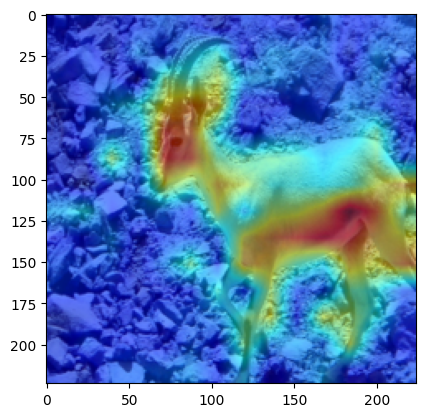

In [464]:
import numpy as np
import cv2

mask = acc_grads

# Reshape mask into size of original image
mask = (mask - mask.min()) / (mask.max() - mask.min())
mask = mask.reshape(1, 1, 14, 14).float()
mask = torch.nn.functional.interpolate(mask, size=224, mode='bilinear')
mask = torch.squeeze(mask).detach().numpy()

# Create heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

# Get image array
im = np.transpose(img_ft[0].detach().numpy(), (1,2,0))
im = (im - im.min()) / (im.max() - im.min())

# Apply headmap to image
vis = heatmap + np.float32(im)
vis = vis / np.max(vis)
vis = np.uint8(255 * vis)
vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

# Plot
plt.imshow(vis)
plt.show()